### Imports

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

import random
import math

# Enable inline plotting
%matplotlib inline

# Train GAN

In [2]:
# Fixing the random seed in order to have a deterministic output
# Remove that line if you want to get different images between training cycles
np.random.seed(1000)

# Dimensionality of the latent vector (Generator's input)
randomDim = 10

num_classes = 10

In [3]:

# Load MNIST data - Note that normalization is a little different than we have used in the past
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:,:,:,np.newaxis]
X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_test = X_test[:,:,:, np.newaxis]

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Optimizer
adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

11493376/11490434 [==============================] - 0s 0us/step


## Generator

In [ ]:
# Generator
generator = keras.Sequential()
generator.add(layers.Dense(7*7*128, input_dim=randomDim))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Reshape((7, 7, 128)))
generator.add(layers.UpSampling2D(size=(2, 2)))
generator.add(layers.Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.UpSampling2D(size=(2, 2)))
generator.add(layers.Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0

## Discriminator

In [ ]:
# Discriminator
discriminator = keras.Sequential()
discriminator.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

## Combined network

In [ ]:
# Combined network
discriminator.trainable = False
ganInput = layers.Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = keras.Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [ ]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         275457    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 488,322
Trainable params: 275,457
Non-trainable params: 212,865
_________________________________________________________________


## Loss Plots

In [45]:
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss():
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Create a wall of generated MNIST images
def plotGeneratedImages(examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i].reshape((28,28)), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Training Loop

In [ ]:
def GAN_train(epochs=1, batchSize=128):
    batchCount = int(X_train.shape[0] / batchSize)
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    for epoch in range(1, epochs+1):
        print('\n','-'*15, 'Epoch ', epoch, '-'*15)
        for batch in range(batchCount):
            print("\rBatch number: %d/%d" % (batch, batchCount), end="")
            
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing - this is done because of the 'sigmoid' output of the discriminator
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if epoch == 1 or epoch % 10 == 0:
            plotGeneratedImages()

    # Plot losses from every epoch
    plotLoss()

## Train The GAN

Epochs: 100
Batch size: 128
Batches per epoch: 468

 --------------- Epoch  1 ---------------
Batch number: 467/468

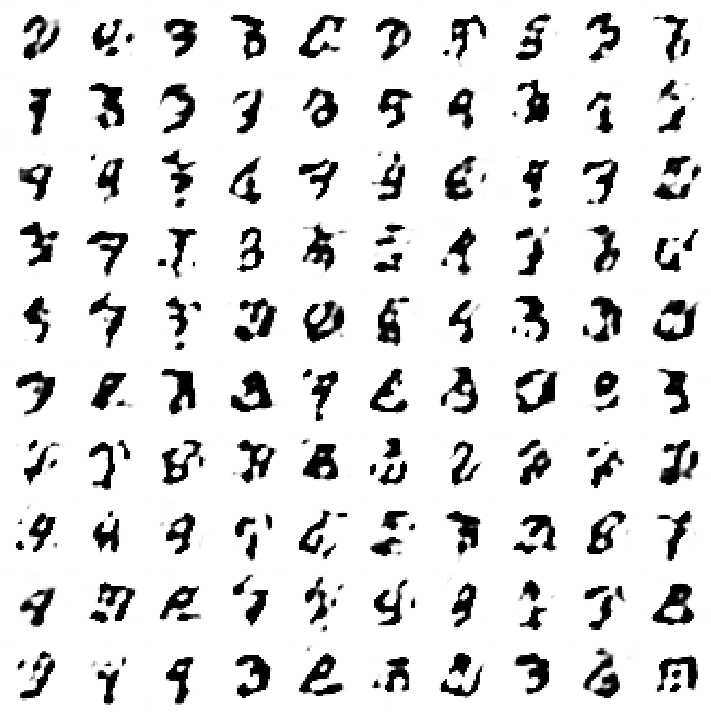


 --------------- Epoch  2 ---------------
Batch number: 467/468
 --------------- Epoch  3 ---------------
Batch number: 467/468
 --------------- Epoch  4 ---------------
Batch number: 467/468
 --------------- Epoch  5 ---------------
Batch number: 467/468
 --------------- Epoch  6 ---------------
Batch number: 467/468
 --------------- Epoch  7 ---------------
Batch number: 467/468
 --------------- Epoch  8 ---------------
Batch number: 467/468
 --------------- Epoch  9 ---------------
Batch number: 467/468
 --------------- Epoch  10 ---------------
Batch number: 467/468

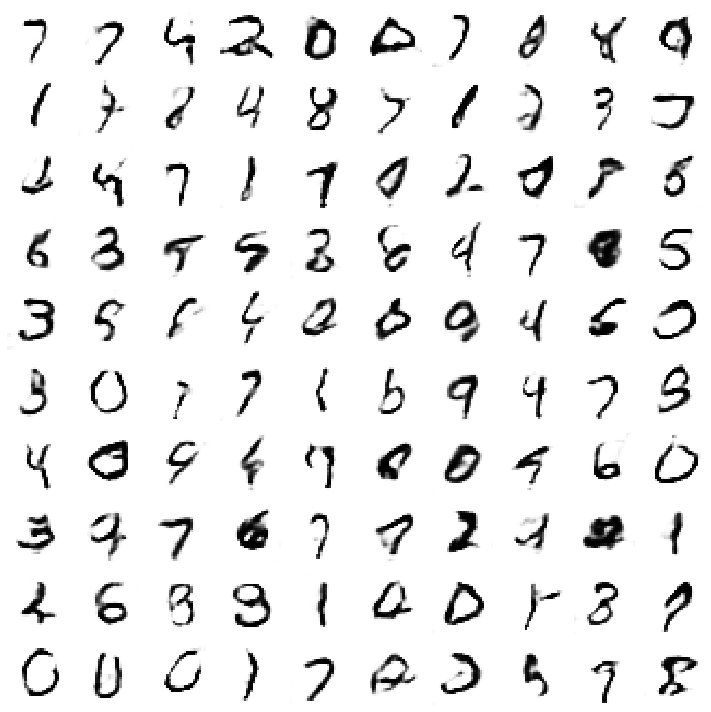


 --------------- Epoch  11 ---------------
Batch number: 467/468
 --------------- Epoch  12 ---------------
Batch number: 467/468
 --------------- Epoch  13 ---------------
Batch number: 467/468
 --------------- Epoch  14 ---------------
Batch number: 467/468
 --------------- Epoch  15 ---------------
Batch number: 467/468
 --------------- Epoch  16 ---------------
Batch number: 467/468
 --------------- Epoch  17 ---------------
Batch number: 467/468
 --------------- Epoch  18 ---------------
Batch number: 467/468
 --------------- Epoch  19 ---------------
Batch number: 467/468
 --------------- Epoch  20 ---------------
Batch number: 467/468

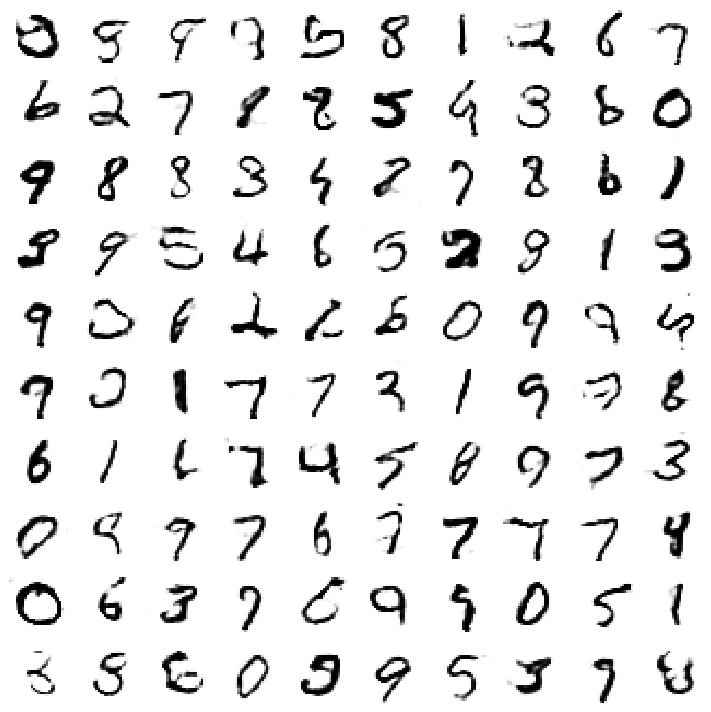


 --------------- Epoch  21 ---------------
Batch number: 467/468
 --------------- Epoch  22 ---------------
Batch number: 467/468
 --------------- Epoch  23 ---------------
Batch number: 467/468
 --------------- Epoch  24 ---------------
Batch number: 467/468
 --------------- Epoch  25 ---------------
Batch number: 467/468
 --------------- Epoch  26 ---------------
Batch number: 467/468
 --------------- Epoch  27 ---------------
Batch number: 467/468
 --------------- Epoch  28 ---------------
Batch number: 467/468
 --------------- Epoch  29 ---------------
Batch number: 467/468
 --------------- Epoch  30 ---------------
Batch number: 467/468

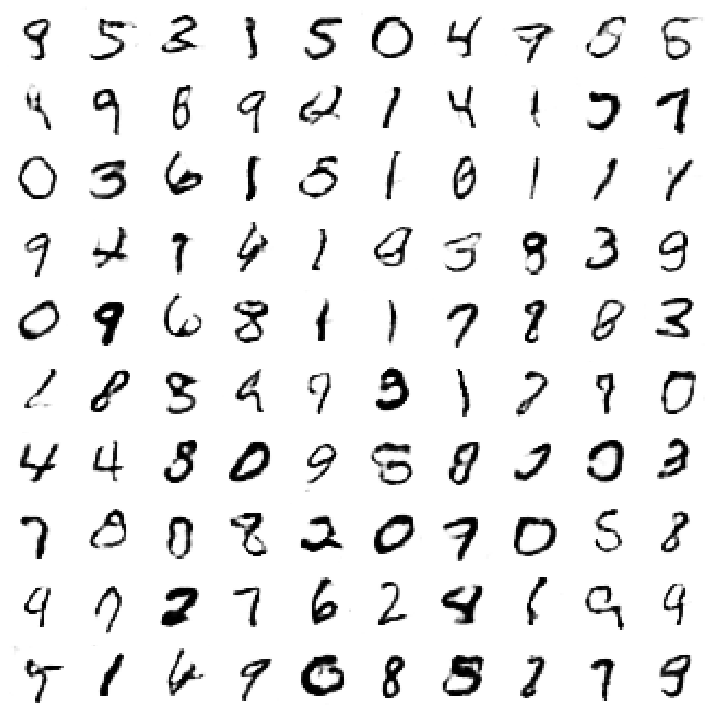


 --------------- Epoch  31 ---------------
Batch number: 467/468
 --------------- Epoch  32 ---------------
Batch number: 467/468
 --------------- Epoch  33 ---------------
Batch number: 467/468
 --------------- Epoch  34 ---------------
Batch number: 467/468
 --------------- Epoch  35 ---------------
Batch number: 467/468
 --------------- Epoch  36 ---------------
Batch number: 467/468
 --------------- Epoch  37 ---------------
Batch number: 467/468
 --------------- Epoch  38 ---------------
Batch number: 467/468
 --------------- Epoch  39 ---------------
Batch number: 467/468
 --------------- Epoch  40 ---------------
Batch number: 467/468

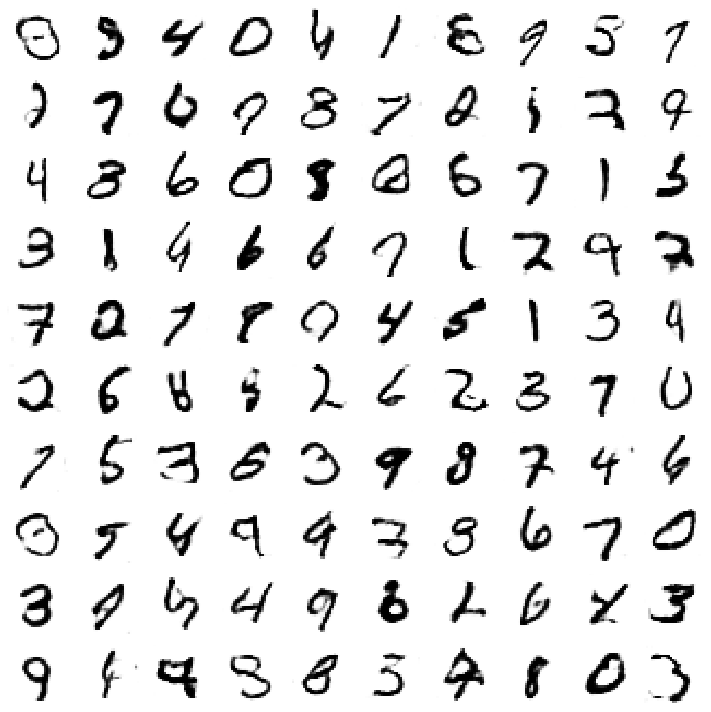


 --------------- Epoch  41 ---------------
Batch number: 467/468
 --------------- Epoch  42 ---------------
Batch number: 467/468
 --------------- Epoch  43 ---------------
Batch number: 467/468
 --------------- Epoch  44 ---------------
Batch number: 467/468
 --------------- Epoch  45 ---------------
Batch number: 467/468
 --------------- Epoch  46 ---------------
Batch number: 467/468
 --------------- Epoch  47 ---------------
Batch number: 467/468
 --------------- Epoch  48 ---------------
Batch number: 467/468
 --------------- Epoch  49 ---------------
Batch number: 467/468
 --------------- Epoch  50 ---------------
Batch number: 467/468

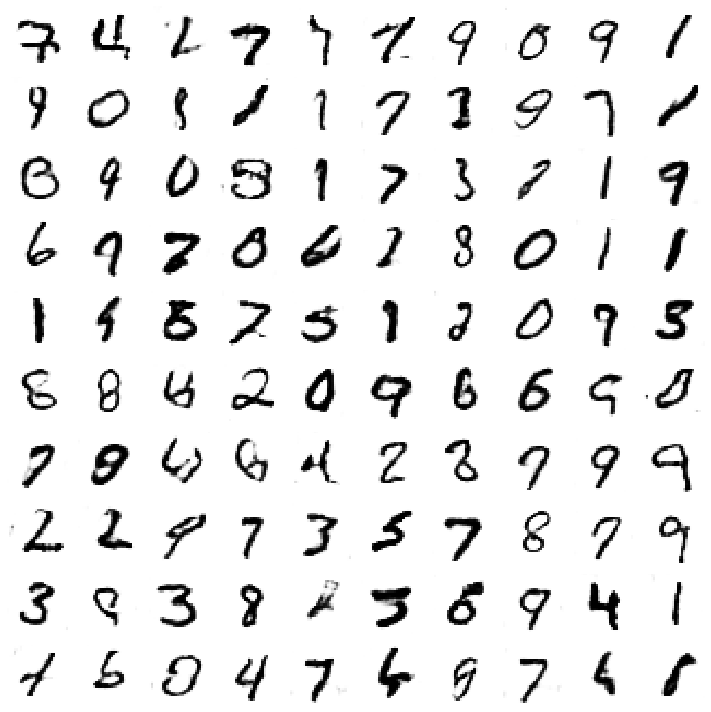


 --------------- Epoch  51 ---------------
Batch number: 467/468
 --------------- Epoch  52 ---------------
Batch number: 467/468
 --------------- Epoch  53 ---------------
Batch number: 467/468
 --------------- Epoch  54 ---------------
Batch number: 467/468
 --------------- Epoch  55 ---------------
Batch number: 467/468
 --------------- Epoch  56 ---------------
Batch number: 467/468
 --------------- Epoch  57 ---------------
Batch number: 467/468
 --------------- Epoch  58 ---------------
Batch number: 467/468
 --------------- Epoch  59 ---------------
Batch number: 467/468
 --------------- Epoch  60 ---------------
Batch number: 467/468

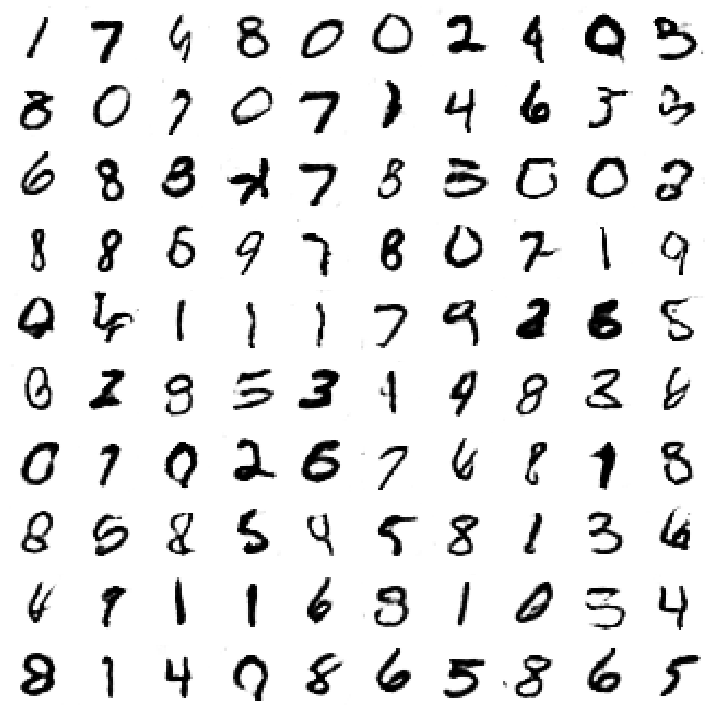


 --------------- Epoch  61 ---------------
Batch number: 467/468
 --------------- Epoch  62 ---------------
Batch number: 467/468
 --------------- Epoch  63 ---------------
Batch number: 467/468
 --------------- Epoch  64 ---------------
Batch number: 467/468
 --------------- Epoch  65 ---------------
Batch number: 467/468
 --------------- Epoch  66 ---------------
Batch number: 467/468
 --------------- Epoch  67 ---------------
Batch number: 467/468
 --------------- Epoch  68 ---------------
Batch number: 467/468
 --------------- Epoch  69 ---------------
Batch number: 467/468
 --------------- Epoch  70 ---------------
Batch number: 467/468

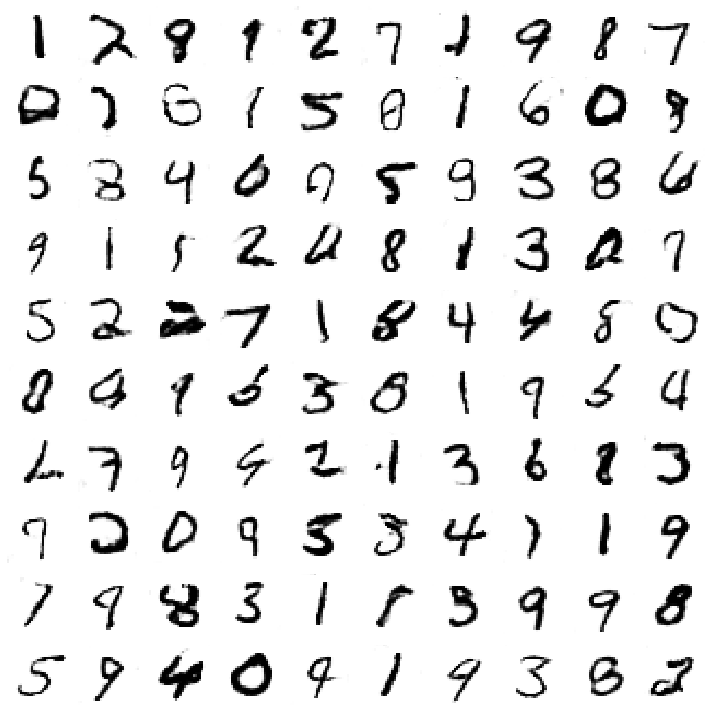


 --------------- Epoch  71 ---------------
Batch number: 467/468
 --------------- Epoch  72 ---------------
Batch number: 467/468
 --------------- Epoch  73 ---------------
Batch number: 467/468
 --------------- Epoch  74 ---------------
Batch number: 467/468
 --------------- Epoch  75 ---------------
Batch number: 467/468
 --------------- Epoch  76 ---------------
Batch number: 467/468
 --------------- Epoch  77 ---------------
Batch number: 467/468
 --------------- Epoch  78 ---------------
Batch number: 467/468
 --------------- Epoch  79 ---------------
Batch number: 467/468
 --------------- Epoch  80 ---------------
Batch number: 467/468

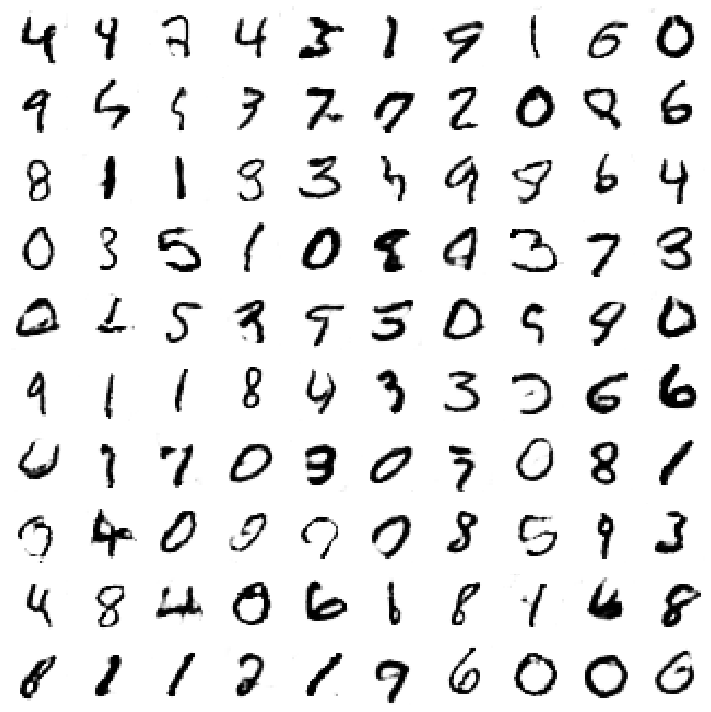


 --------------- Epoch  81 ---------------
Batch number: 467/468
 --------------- Epoch  82 ---------------
Batch number: 467/468
 --------------- Epoch  83 ---------------
Batch number: 467/468
 --------------- Epoch  84 ---------------
Batch number: 467/468
 --------------- Epoch  85 ---------------
Batch number: 467/468
 --------------- Epoch  86 ---------------
Batch number: 467/468
 --------------- Epoch  87 ---------------
Batch number: 467/468
 --------------- Epoch  88 ---------------
Batch number: 467/468
 --------------- Epoch  89 ---------------
Batch number: 467/468
 --------------- Epoch  90 ---------------
Batch number: 467/468

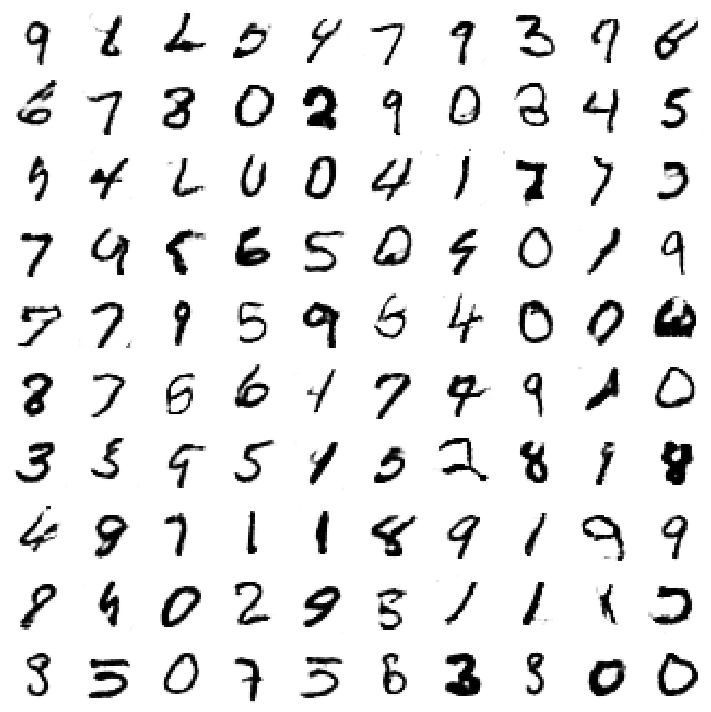


 --------------- Epoch  91 ---------------
Batch number: 467/468
 --------------- Epoch  92 ---------------
Batch number: 467/468
 --------------- Epoch  93 ---------------
Batch number: 467/468
 --------------- Epoch  94 ---------------
Batch number: 467/468
 --------------- Epoch  95 ---------------
Batch number: 467/468
 --------------- Epoch  96 ---------------
Batch number: 467/468
 --------------- Epoch  97 ---------------
Batch number: 467/468
 --------------- Epoch  98 ---------------
Batch number: 467/468
 --------------- Epoch  99 ---------------
Batch number: 467/468
 --------------- Epoch  100 ---------------
Batch number: 467/468

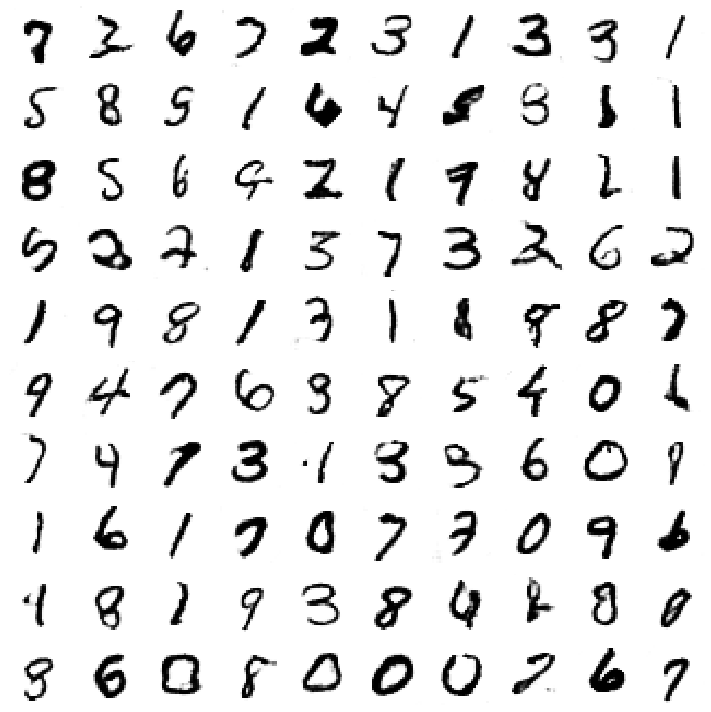

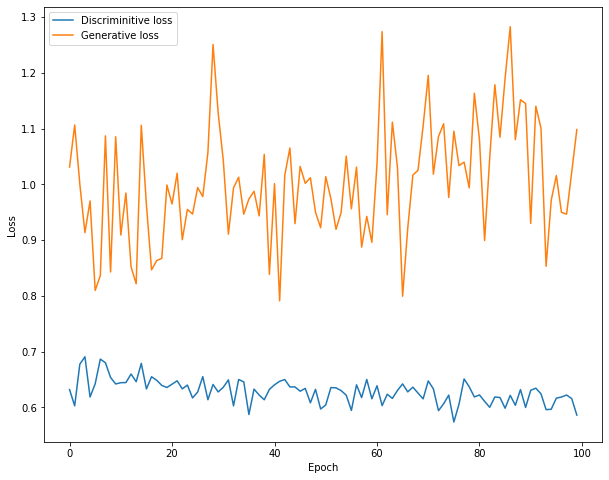

In [ ]:
GAN_train(100, 128)

## Plot Generated Images From The Generator

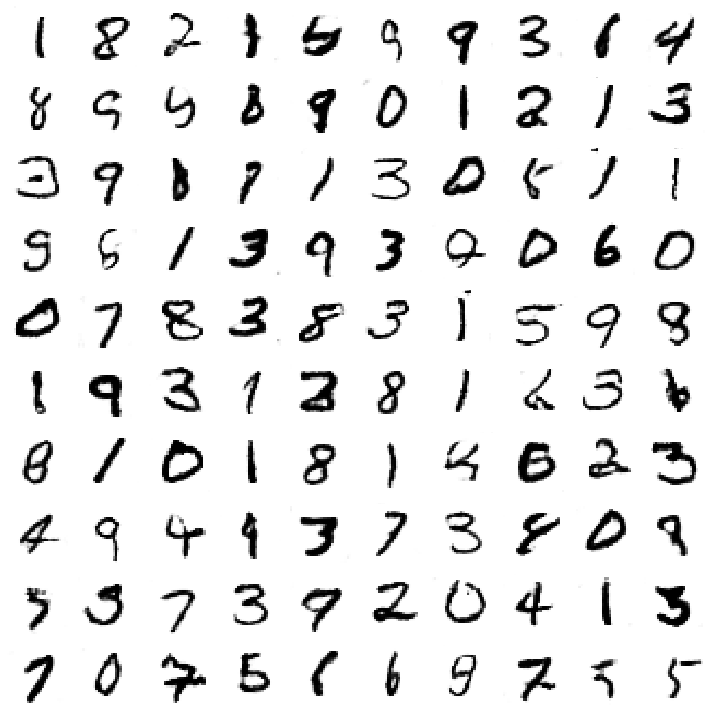

In [46]:
plotGeneratedImages()

# Train Classifier

## Classifier

In [ ]:
activation = 'relu'
# input image dimensions
img_rows, img_cols, img_colors = 28, 28, 1

classifier = keras.Sequential()
classifier.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
classifier.add(layers.Conv2D(8, (3, 3), activation=activation))
classifier.add(layers.MaxPooling2D(pool_size=(2, 2)))
classifier.add(layers.Dropout(0.25))
classifier.add(layers.Flatten())
classifier.add(layers.Dense(128, activation=activation))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(num_classes))
classifier.add(layers.Activation('softmax', name='y_pred'))
classifier.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adadelta(),
            metrics=[keras.metrics.CategoricalAccuracy()])

## Train Classifier

In [ ]:
batch_size = 128
maxepoches = 12
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20
  

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)


history = classifier.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=maxepoches,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks=[reduce_lr])

Epoch 1/12
469/469 [==============================] - 4s 8ms/step - loss: 1.0080 - categorical_accuracy: 0.6723 - val_loss: 0.3011 - val_categorical_accuracy: 0.9191
Epoch 2/12
469/469 [==============================] - 3s 7ms/step - loss: 0.4262 - categorical_accuracy: 0.8684 - val_loss: 0.2109 - val_categorical_accuracy: 0.9403
Epoch 3/12
469/469 [==============================] - 3s 7ms/step - loss: 0.3322 - categorical_accuracy: 0.8976 - val_loss: 0.1675 - val_categorical_accuracy: 0.9521
Epoch 4/12
469/469 [==============================] - 3s 7ms/step - loss: 0.2770 - categorical_accuracy: 0.9155 - val_loss: 0.1405 - val_categorical_accuracy: 0.9588
Epoch 5/12
469/469 [==============================] - 3s 7ms/step - loss: 0.2462 - categorical_accuracy: 0.9255 - val_loss: 0.1224 - val_categorical_accuracy: 0.9637
Epoch 6/12
469/469 [==============================] - 3s 7ms/step - loss: 0.2213 - categorical_accuracy: 0.9336 - val_loss: 0.1113 - val_categorical_accuracy: 0.9676
Epoc

# Detector

In [177]:
def detect(x, epsilon=0.05):
  generator.trainable = False
  classifier.trainable = False
  mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

  # Get a random vector of input noise
  z = np.random.normal(0, 1, size=[1,randomDim])
  z = tf.Variable(z, trainable=True)

  opt = tf.keras.optimizers.Adam(learning_rate=0.03)
  loss_fn = lambda: mse(tf.squeeze(generator(z, training=False)), x.squeeze())
  var_list_fn = lambda: z

  for _ in range(1000):
    opt.minimize(loss_fn, var_list_fn)

  if mse(tf.squeeze(generator(z, training=False)), x.squeeze()) < epsilon:
    return classifier(generator(z, training=False), training=False)

  else:
    return 'adversarial'

## Detector On Test Set

In [178]:
def detector_with_valid(dim=(10, 10)):
  fp = 0
  imageBatch = X_test[np.random.randint(0, X_test.shape[0], size=400)]

  for i, image in enumerate(imageBatch):
    pred = detect(image)
    if isinstance(pred, str):
      fp += 1
    else:
      pass


  print(f' False Positive detection rate of the detector is: {fp/len(imageBatch)}')


In [179]:
detector_with_valid()

 False Positive detection rate of the detector is: 0.6775


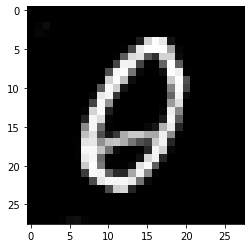

In [43]:
noise = np.random.normal(0, 1, size=[1, randomDim])
gen_z = generator(noise, training=False)
plt.imshow(gen_z[0, :, : ,0], cmap='gray')

# Save And Load Models

In [ ]:
# generator.save('save_model/generator')
# discriminator.save('save_model/discriminator')
# classifier.save('save_model/classifier')

INFO:tensorflow:Assets written to: save_model/generator/assets
INFO:tensorflow:Assets written to: save_model/discriminator/assets
INFO:tensorflow:Assets written to: save_model/classifier/assets


In [ ]:
!cp -r save_model/* /content/drive/MyDrive/Projects/Adverserial_Learning_Yandex/assignment5/save_model

In [5]:
generator = tf.keras.models.load_model('/content/drive/MyDrive/Projects/Adverserial_Learning_Yandex/assignment5/save_model/generator/', custom_objects=None, compile=True, options=None)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0

In [6]:
classifier = tf.keras.models.load_model('/content/drive/MyDrive/Projects/Adverserial_Learning_Yandex/assignment5/save_model/classifier', custom_objects=None, compile=True, options=None)
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               147584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [7]:
generator.trainable = False
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0

In [8]:
classifier.trainable = False
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               147584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              